## CSD and first-derivative on source reconstructed laminar traces 

We test different CSD methods (second derivative of the signal) and first-derivative on source reconstructed laminar activity during an evoked response. 

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
import k3d
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt
import tempfile
from scipy.signal import resample
from scipy.ndimage import gaussian_filter1d

from lameg.laminar import compute_csd
from lameg.simulate import run_current_density_simulation, run_dipole_simulation
from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.util import get_fiducial_coords, get_bigbrain_layer_boundaries
from lameg.viz import plot_csd
import spm_standalone

In [12]:
%env SUBJECTS_DIR=/home/common/bonaiuto/cued_action_meg/derivatives/processed/fs/

env: SUBJECTS_DIR=/home/common/bonaiuto/cued_action_meg/derivatives/processed/fs/


In [7]:
n_trials=10

In [2]:
subj_id='sub-001'
ses_id = 'ses-01'
epoch='motor'
c_idx=3
subj_dir=os.path.join('/home/common/bonaiuto/cued_action_meg/derivatives/processed',subj_id)
subj_surf_dir=os.path.join(subj_dir,'surf')
multilayer_mesh_fname = os.path.join(subj_surf_dir, 'multilayer.11.ds.link_vector.fixed.gii')

# External dependencies of the doc
subj_id = 'sub-001'

mri_fname = os.path.join(subj_dir, 't1w.nii' )
data_file=os.path.join(subj_dir, ses_id, f'spm/pcspm_converted_autoreject-{subj_id}-{ses_id}-{epoch}-epo.mat')
out_dir=os.path.join('./data', subj_id, ses_id, f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_model_inv')

fiducial_fname='/home/common/bonaiuto/cued_action_meg/raw/participants.tsv'
nas, lpa, rpa=get_fiducial_coords(subj_id, fiducial_fname)

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(out_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(out_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(out_dir, f'{data_base}.mat')

In [4]:
spm = spm_standalone.initialize()

In [5]:
# Compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

sim_vertex = 5195

In [6]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

peak = sim_vertex

layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
thickness = np.sqrt(np.sum((layer_coords[0,:]-layer_coords[-1,:])**2))

s_rate = 600

# Get source time series for each layer
layer_ts, time, _ = load_source_time_series(base_fname, vertices=layer_verts)
layer_ts = layer_ts * -1
mean_layer_ts = np.mean(layer_ts,axis=-1)

[csd, smooth_csd] = compute_csd(mean_layer_ts,thickness,600,smoothing='cubic')


SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
28-Apr-2025 08:24:25 - Running job #1
------------------------------------------------------------------------
28-Apr-2025 08:24:25 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:24:26 - 28/04/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-1000 1000]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 275
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -4.0874e+06
      PostMax: [320430x1 double]
            A: [275x275 double]
           Ip: [1x512 double]
            M: [320430x275 double]
            J: {[320430x4 double]}
            L: [275x320430 double]
           qC: [320430x1 double]
        tempU: [1025x1025 double]
            V: [1025x4 double]
           qV: [1201x1201 double]
            T: [1201x4 double]
            U: {[275x275 double]}
           Is: [1x320430 double]
           It: [1x1201 double]
           Ik: [1x531 double]
           Ic: {[1x275 double]}
           Nd: 320430
          pst: [1x1201 double]
          dct: [1x1025 double]
           ID: 547.4527
            F: -4.0874e+06
           R2: 99.9024
         

## Simulate synthetic sensor level data
- define how to simulate (w/ dipole & orientations or with current density)
- retrieve the dipole needed
- at different layers 
- then reconstruct the source
- and compute the CSD, KCSD and first derivative

In [8]:
# Size of simulated sources (mm)
sim_dipfwhm=[5 for x in range(n_layers)] # mm
# SNR of simulated data (dB)
SNR = 0

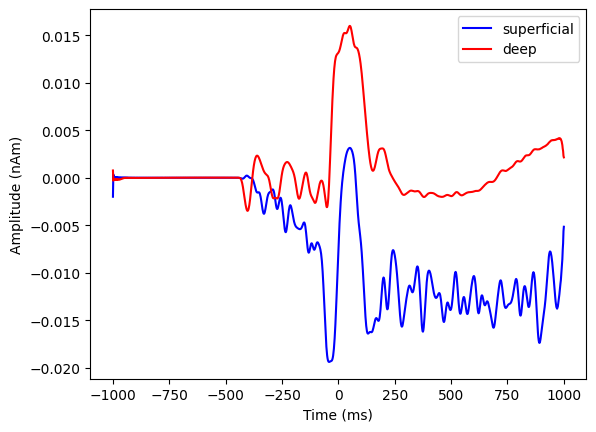

In [9]:
# Simulated signal
dipole_erf = np.loadtxt(os.path.join('./data',subj_id,ses_id,f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_hnn',f'dipole_merf_{n_trials}t.txt'))
dipole_erf = dipole_erf.T

exp_dpl = np.loadtxt(os.path.join('./data',subj_id,ses_id,f'{subj_id}_{ses_id}_c{c_idx}_{epoch}/hnn_input/',f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_erf.txt'))
exp_dpl.T

tot_signal = dipole_erf[1,:]
L2_signal = dipole_erf[2,:]
L5_signal = dipole_erf[3,:]
time = dipole_erf[0, :] 

new_time = np.linspace(-1000, 1000, 1201)

sfreq_new = 600
sfreq_original = len(time) // (time[-1]/1000 - time[0]/1000)

n_samples_new = int(len(time) * sfreq_new / sfreq_original) + 1

tot_signal_d = resample(tot_signal, n_samples_new)
L2_signal_d = resample(L2_signal, n_samples_new)
L5_signal_d = resample(L5_signal, n_samples_new)

dipole_moment = [0.001 for x in range(n_layers)]

plt.plot(new_time,L2_signal_d*dipole_moment[0], 'b', label='superficial')
plt.plot(new_time,L5_signal_d*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (nAm)')
plt.savefig('dipole_merf_50t_1.svg')

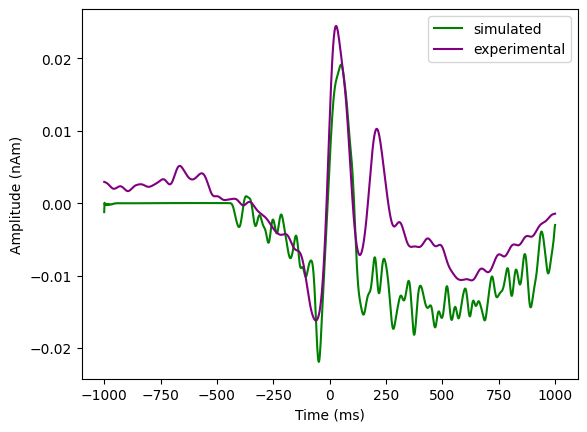

In [10]:
plt.plot(new_time,tot_signal_d*dipole_moment[1], 'g', label='simulated')
plt.plot(new_time,exp_dpl[:,1]*dipole_moment[1], color='purple', label='experimental')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (nAm)')
plt.savefig('dipole_merf_50t_2.svg')

In [13]:
vert_bb_prop = get_bigbrain_layer_boundaries(subj_id, subj_surf_dir)

In [14]:
lam_layer=vert_bb_prop[:,sim_vertex]*n_layers
twothree_center=int(lam_layer[0]+(lam_layer[2]-lam_layer[0])*.5)
five_center=int(lam_layer[3]+(lam_layer[4]-lam_layer[3])*.5)

In [15]:
lam_layer

array([ 1.00253158,  1.55332218,  4.5374229 ,  4.85566807,  7.92166632,
       11.        ])

In [16]:
twothree_center

2

In [17]:
five_center

6

In [18]:
signal=np.zeros((11,len(L2_signal_d)))
signal[twothree_center,:]=L2_signal_d
signal[five_center,:]=L5_signal_d
sim_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]

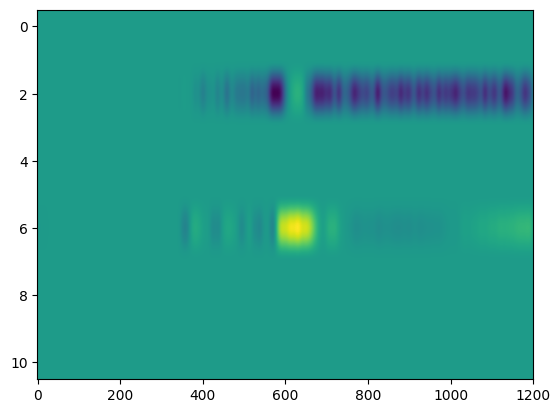

In [19]:
plt.imshow(signal,aspect='auto')

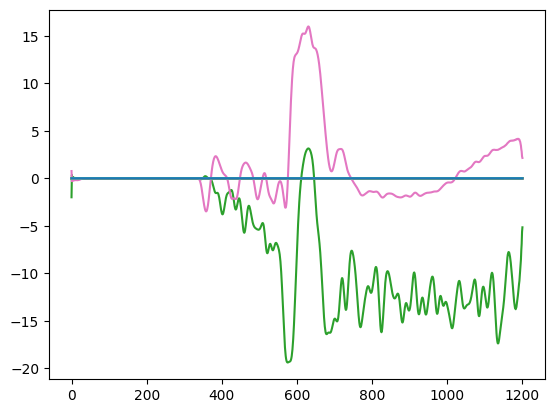

In [20]:
plt.plot(signal.T)

In [21]:
prefix = f'sim_{sim_vertex}_merf_'

l_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    sim_verts,
    signal, 
    [x for x in dipole_moment], 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)  

[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    l_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes, 
    viz=False,
    spm_instance=spm
)

# Layer peak
peak = sim_vertex

s_rate = 600

# Get source time series for each layer
sim_layer_ts, time, _ = load_source_time_series(l_sim_fname, vertices=layer_verts)

sim_mean_layer_ts = np.mean(sim_layer_ts,axis=-1)
[sim_csd, sim_smooth_csd] = compute_csd(sim_mean_layer_ts,thickness,s_rate,smoothing='cubic')

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/laminar_csd/data/sub-001/ses-01/sub-001_ses-01_c3_motor_model_inv/simprior_sim_5195_merf_pcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 11 fixed patches

 In last iteration...setting up patch 1 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.06 pAm/mm2, peak momemnt density 0.14 pAm/mm2 

 In last iteration...setting up patch 2 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.06 pAm/mm2, peak momemnt density 0.14 pAm/mm2 

 In last iteration...setting up patch 3 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.06 pAm/mm2, peak momemnt density 0.14 pAm/mm2 

 In last iteration...setting up patch 4 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.07 pAm/mm2, peak momemnt den

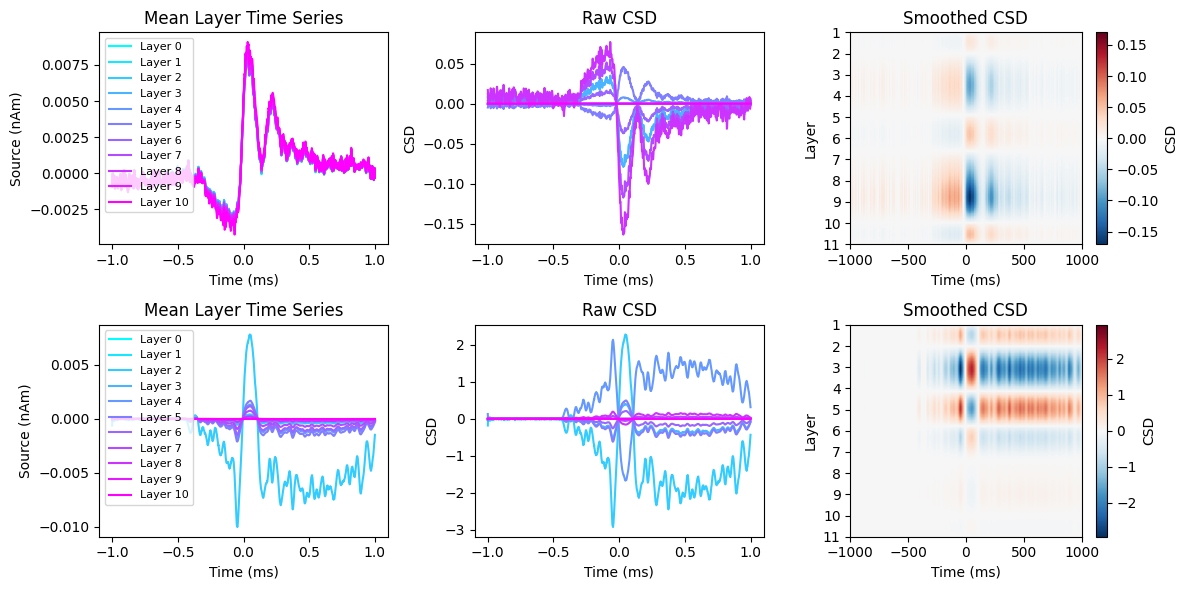

In [22]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

fig = plt.figure(figsize=(12,6))

ax1=plt.subplot(2,3,1)
for l in range(n_layers):
    ax1.plot(time, mean_layer_ts[l, :], label=f'Layer {l}', color=col_r[l, :])
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title('Mean Layer Time Series')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Source (nAm)')

ax2=plt.subplot(2,3,2)
for l in range(n_layers):
    ax2.plot(time, csd[l, :], label=f'Layer {l}', color=col_r[l, :])
ax2.set_title('Raw CSD')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('CSD')

ax3=plt.subplot(2,3,3)
plot_csd(smooth_csd, time*1000, ax3, n_layers=n_layers)
ax3.set_title('Smoothed CSD')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Layer')

ax1=plt.subplot(2,3,4)
for l in range(n_layers):
    ax1.plot(time, sim_mean_layer_ts[l, :], label=f'Layer {l}', color=col_r[l, :])
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title('Mean Layer Time Series')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Source (nAm)')

ax2=plt.subplot(2,3,5)
for l in range(n_layers):
    ax2.plot(time, sim_csd[l, :], label=f'Layer {l}', color=col_r[l, :])
ax2.set_title('Raw CSD')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('CSD')

ax3=plt.subplot(2,3,6)
plot_csd(sim_smooth_csd, time*1000, ax3, n_layers=n_layers)
ax3.set_title('Smoothed CSD')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Layer')